<a href="https://colab.research.google.com/github/yaskhalil/Benchmark-STP-vs-MLLR/blob/main/TP53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup


Crispr File: [Download Link](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap%20Public%2025Q3&filename=CRISPRGeneEffect.csv)

Import the file into the lab once downloaded

In [7]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


# File

gene_import = '/content/CRISPR_(DepMap_Public_25Q3+Score,_Chronos)_subsetted.csv'
gene_file = pd.read_csv(gene_import)

print("Succesful uploa!!")

In [10]:
gene_data = pd.DataFrame(gene_file)

In [11]:
# --- Uncomment if needed ---
#gene_data.head()
#gene_data.describe()

In [19]:
# clean data by removing NA with 90% na
limit = len(gene_data) * .9
filtered_with_index = gene_data.dropna(thresh=limit, axis=1)

In [13]:
filtered_data = filtered_with_index.iloc[:,1:]

In [14]:
# Use imputer to fill values of 90%+ filled genes
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(filtered_data)

In [15]:
# set pca model and number of components
pca = PCA(n_components=2)

In [16]:
principle_comonents = pca.fit_transform(imputed_data)
print("PCA complete")

In [17]:
print(principle_comonents)

[[-4.53882213 -1.57748814]
 [-8.5770925  -3.70953462]
 [ 4.58814498 -4.72081096]
 ...
 [-0.14014891  1.20731062]
 [ 5.09388731 -1.48436962]
 [-0.44981022 -5.66015751]]


# TP53 NETWORK
#### Filtering for ppi's used in MaBoSS

In [20]:
# Theta threshold
theta = -1.0

# binary table: 1 if gene is NOT a dependency, 0 if it IS a dependency
# 0 usually means the gene is inactive.
binary_states = filtered_with_index.iloc[:, 1:].map(
    lambda x: 0 if x <= theta else 1)

# Filter for just the 7-10 genes in your p53 network
p53_genes = ['TP53', 'MDM2', 'ATM', 'TP53I3', 'TP53BP1']

target_cols = [col for col in binary_states.columns if any(
    g in col for g in p53_genes)]

final_states = binary_states[target_cols]

In [18]:
# Extract the weights (loadings) of each gene for PC1
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=filtered_with_index.columns[1:]
)

# Sort by PC1 to see which p53-related genes are most influential
top_genes = loadings.abs().sort_values(by='PC1', ascending=False)
print(top_genes.head(10))

             PC1       PC2
AIRIM   0.095472  0.019822
YARS2   0.083485  0.003617
MARS2   0.078210  0.001416
RPP21   0.071208  0.021923
MRPL57  0.065959  0.008505
WDR18   0.061058  0.014622
LONP1   0.060923  0.019638
SOD2    0.059743  0.009934
MRPL43  0.059534  0.002939
ADSL    0.059447  0.017618


Cell lines distribution based on their dependency profiles.

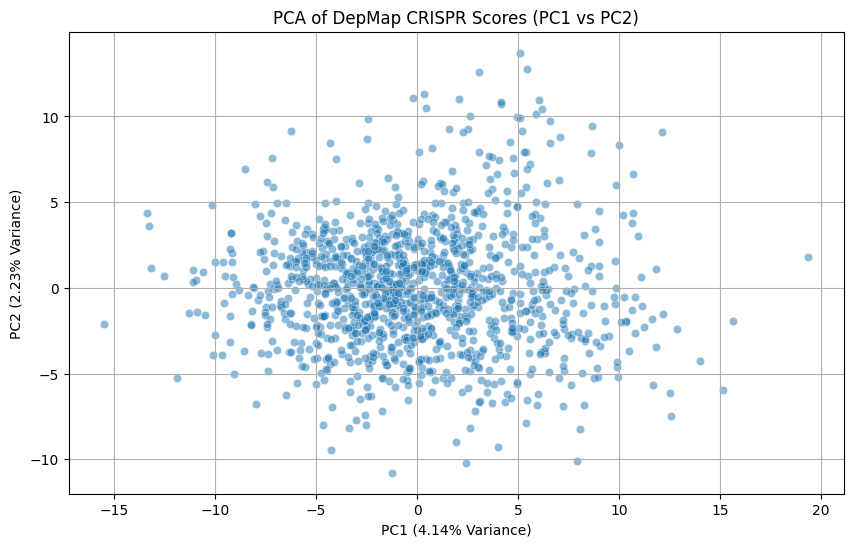

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=principle_comonents[:, 0], y=principle_comonents[:, 1], alpha=0.5)
plt.title('PCA of DepMap CRISPR Scores (PC1 vs PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.grid(True)
plt.show()

Genes driving varience in PC1 loadings

/tmp/ipython-input-1495747896.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15['PC1'], y=top_15.index, palette='viridis')


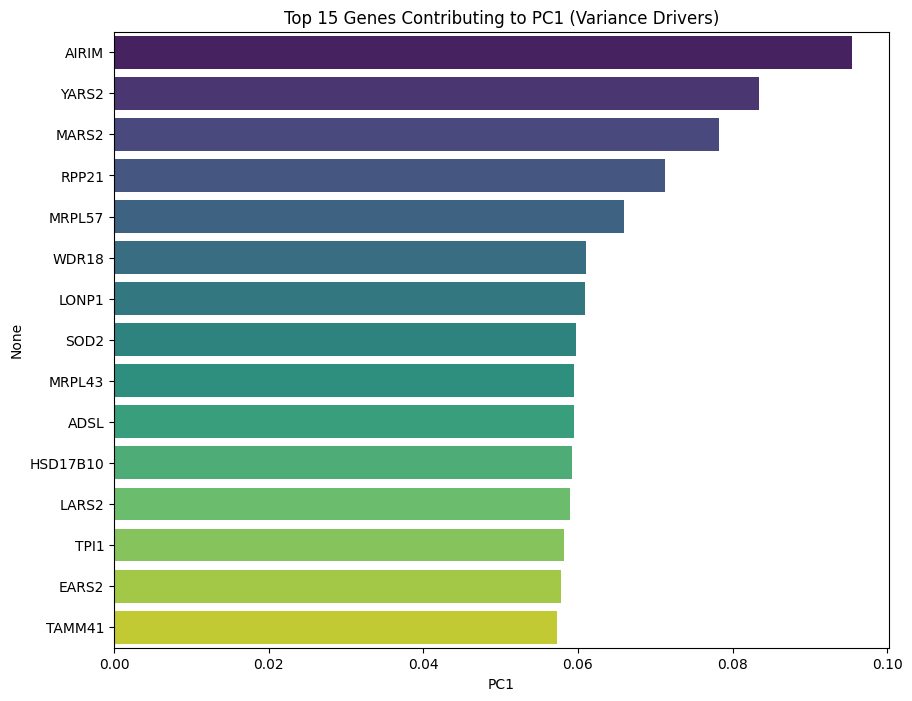

In [23]:
plt.figure(figsize=(10, 8))
top_15 = top_genes.head(15)
sns.barplot(x=top_15['PC1'], y=top_15.index, palette='viridis')
plt.title('Top 15 Genes Contributing to PC1 (Variance Drivers)')
plt.show()

Θ ≤ -1.0 binzarization of 5 target genes in first 50 cells

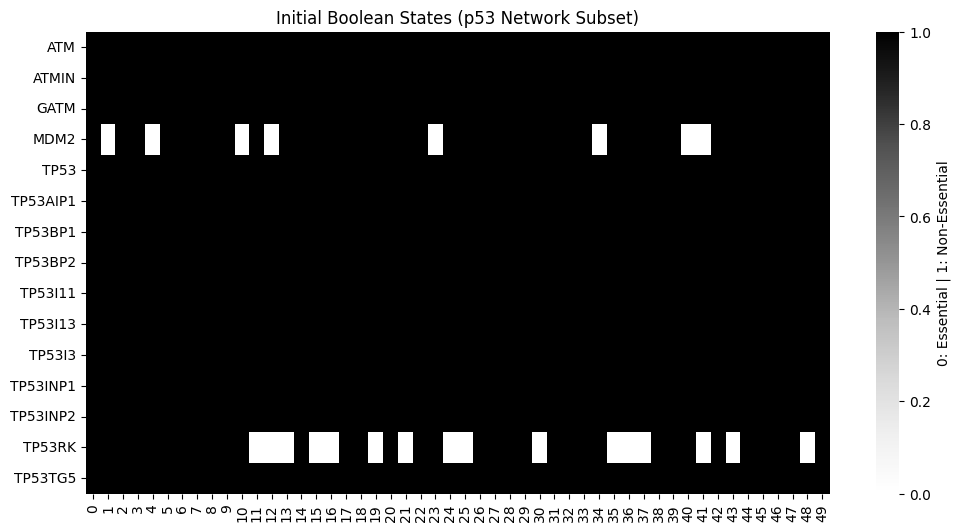

In [24]:
plt.figure(figsize=(12, 6))
sns.heatmap(final_states.head(50).T, cmap='Greys', cbar_kws={'label': '0: Essential | 1: Non-Essential'})
plt.title('Initial Boolean States (p53 Network Subset)')
plt.show()

# Connections of small 4 gene p53 MDM2 network

citation:
  Naldi A, Hernandez C, Abou-Jaoudé W, Monteiro PT, Chaouiya C, Thieffry D. Logical Modeling and Analysis of Cellular Regulatory Networks With GINsim 3.0. Front Physiol. 2018 Jun 19;9:646. doi: 10.3389/fphys.2018.00646. PMID: 29971008; PMCID: PMC6018412.

  [Read text](https://pmc.ncbi.nlm.nih.gov/articles/PMC6018412/)

In [ ]:
# p53-Mdm2 Logic derived from the regulatory graph
p53_logic = {
    "p53": "not Mdm2nuc",
    "Mdm2cyt": "p53",
    "Mdm2nuc": "Mdm2cyt and not DNAdam and not p53",
    "DNAdam": "DNAdam and not p53"
}